<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/23_3_Apple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**В домашней работе вам необходимо:**
1. Выбрать любую понравившуюся модель из [практической](https://colab.research.google.com/drive/1-D-qXFYJ9b5sLLz_CFkUYmR-I2tM7KO2) части урока.
2. Используя известный [датасет](https://storage.yandexcloud.net/academy.ai/AAPL.csv) котировок Apple, обучить модель. Вывести графики из урока: график процесса обучения, сопоставления базового и прогнозного рядов, а также график автокорреляции.
3. Для получения трех проходных баллов за урок необходимо скорректировать код урока для данных с batch_size не равному 1.
4. Хотите 4 балла? Возьмите полносвязанную модель или с одномерной сверткой. Добейтесь подбором параметров и выбором архитектуры идеального графика автокорреляции без холмиков, равномерно спадающих графиков эталонной и прогнозной автокорреляции, максимально близко друг к другу.
5. Для получения дополнительного балла вам необходимо избавиться от тренда с помощью дифференцирования в датасете.
6. Еще один балл можно получить сверху, если догадаетесь как на графике сопоставления базового и прогнозного рядов отобразить реальную дату, а не относительную.

In [271]:
import numpy as np
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization
from keras.layers import Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D
from keras.layers import MaxPooling1D, RepeatVector
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

import warnings
warnings.filterwarnings('ignore')

In [272]:
!wget https://storage.yandexcloud.net/academy.ai/AAPL.csv

price = pd.read_csv("./AAPL.csv", index_col='Date', usecols = ['Adj Close', 'Volume', 'Date'], parse_dates=['Date'])
price.head(5)

--2024-10-20 05:18:31--  https://storage.yandexcloud.net/academy.ai/AAPL.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186539 (182K) [text/csv]
Saving to: ‘AAPL.csv.5’

AAPL.csv.5          100%[===================>] 182.17K   311KB/s    in 0.6s    

2024-10-20 05:18:32 (311 KB/s) - ‘AAPL.csv.5’ saved [186539/186539]



,Adj Close,Volume
Date,,
2014-01-02,17.296652,234684800
2014-01-03,16.916719,392467600
2014-01-06,17.008968,412610800
2014-01-07,16.887323,317209200
2014-01-08,16.994270,258529600


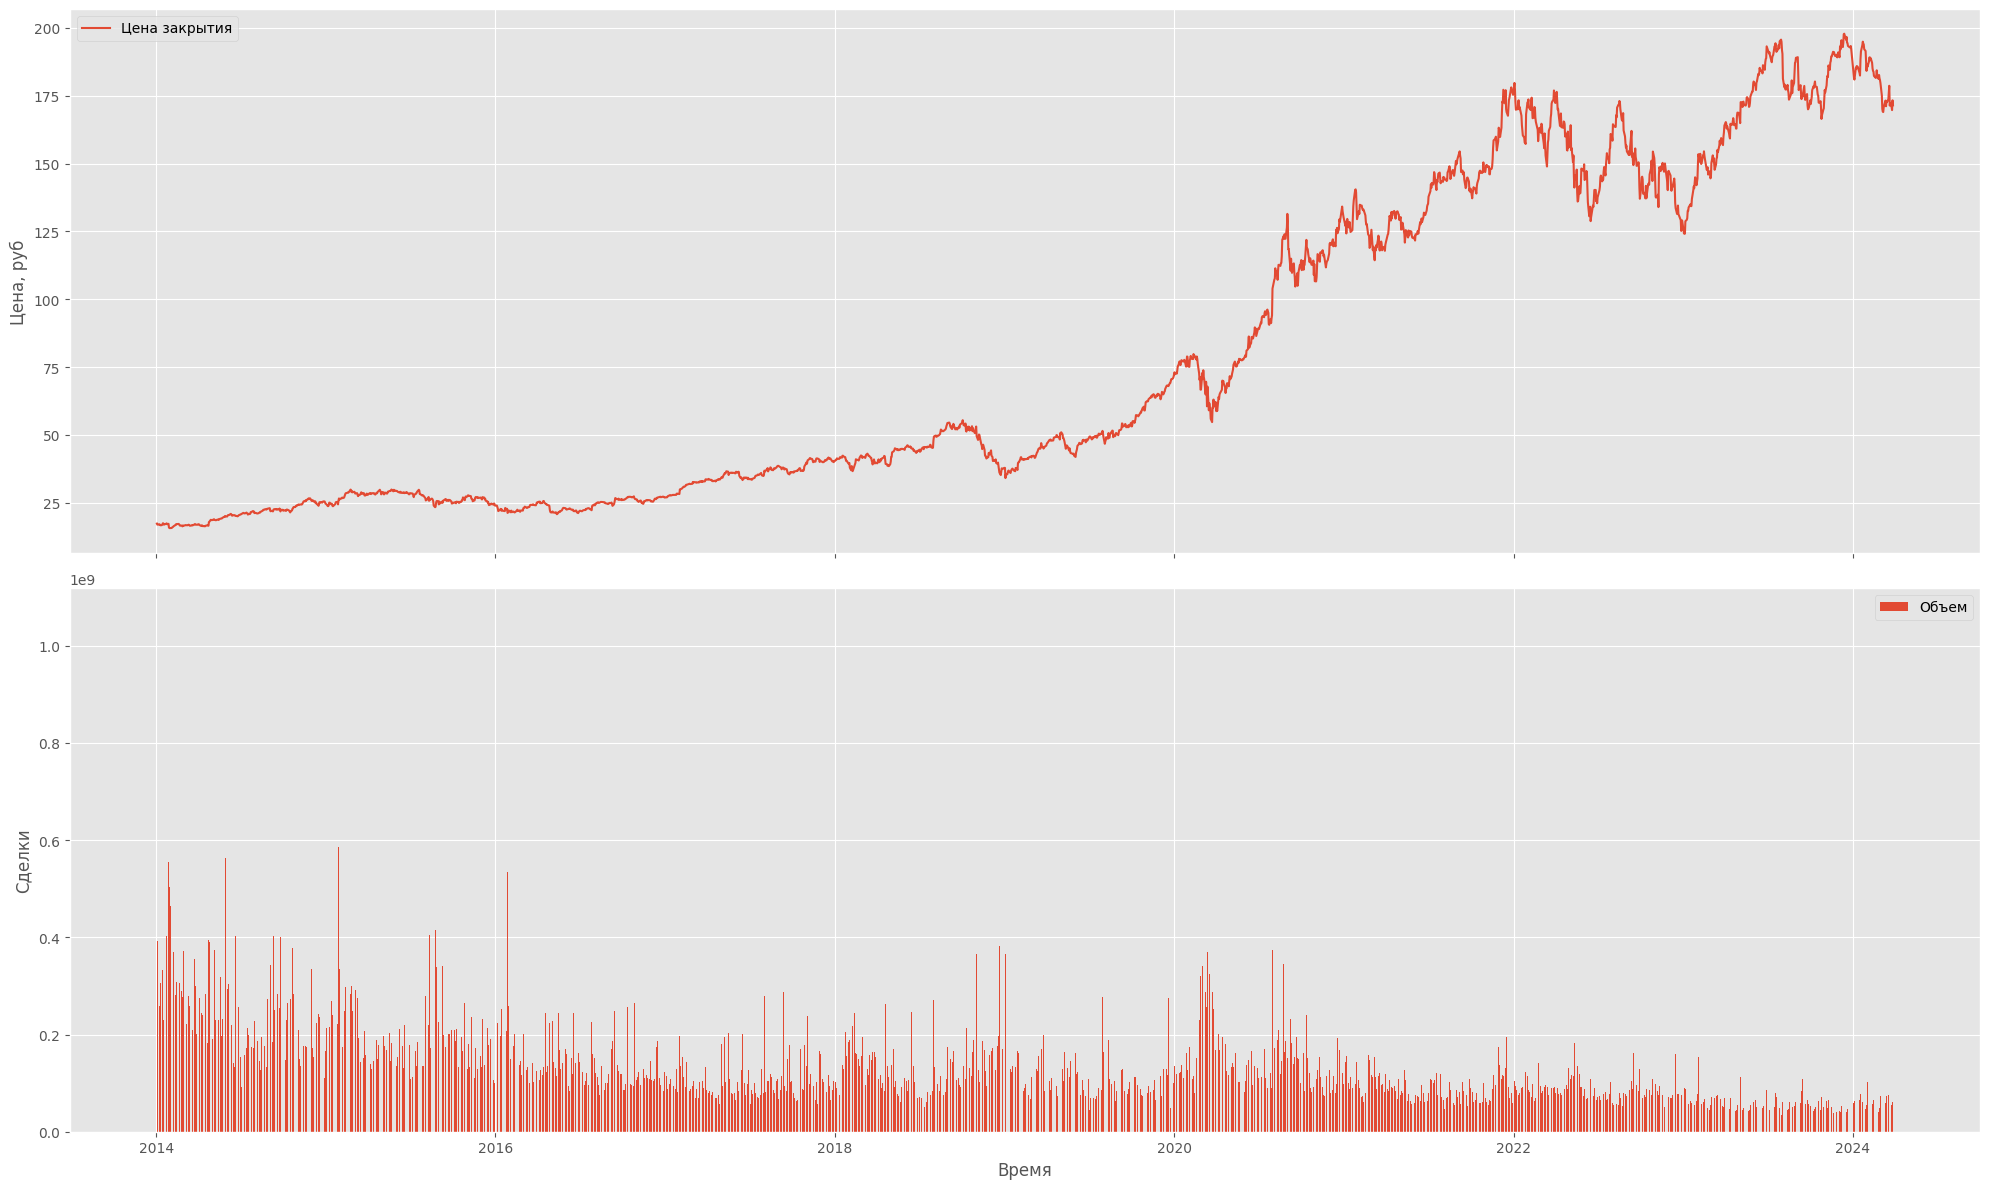

In [273]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True)

ax1.plot(price.index, price['Adj Close'], label='Цена закрытия')
ax1.set_ylabel('Цена, руб')
ax1.legend()

ax2.bar(x=price.index, height=price['Volume'], label='Объем')
ax2.set_ylabel('Сделки')
ax2.legend()

plt.xlabel('Время')
plt.tight_layout()

plt.show()

In [274]:
# Функция вычисления коэффициента автокорреляции

def get_corr_coef(
    data, # данные
    lag   # временной лаг
    ):

    array_data = np.asarray(data) # Преобразуем в массив NumPy

    # вычисление матрицы коэффициентов и отбор коэффициента из нужного места матрицы
    return np.corrcoef(array_data[lag:], array_data[:-lag])[0, 1]

In [275]:
np.round(get_corr_coef(price['Adj Close'], 5), 2)

1.0

In [276]:
np.round(get_corr_coef(np.diff(price['Adj Close']), 5), 3)

0.032

In [277]:
price.drop(columns=['Volume'], inplace=True)
price.tail(5)

,Adj Close
Date,
2024-03-22,172.279999
2024-03-25,170.850006
2024-03-26,169.710007
2024-03-27,173.309998
2024-03-28,171.479996


In [278]:
train_data = price[:'2023-01-10']
test_data = price['2023-01-20':]

In [279]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [280]:
print(f'Тренировочные данные: {scaled_train_data.shape}')
print(f'Тестовые данные: {scaled_test_data.shape}')

Тренировочные данные: (2272, 1)
Тестовые данные: (299, 1)


In [281]:
# from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

n_input = 14  # Размерность входных данных
n_features = 1 # Размерность выходных данных
BATCH_SIZE = 2 # Размер пакета   <##################################### здесь я выбрал размер батча 2!!!

generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=BATCH_SIZE)
print(f'Форма обучающего пакета: {generator[0][0].shape}, y: {generator[0][1].shape}')

Форма обучающего пакета: (2, 14, 1), y: (2, 1)


In [282]:
validator = TimeseriesGenerator(scaled_test_data, scaled_test_data, length=n_input, batch_size=BATCH_SIZE)
print(f'Форма валидационного пакета: {validator[0][0].shape}, y: {validator[0][1].shape}')

Форма валидационного пакета: (2, 14, 1), y: (2, 1)


In [283]:
tester = TimeseriesGenerator(scaled_test_data, scaled_test_data, length=n_input, batch_size=scaled_test_data.shape[0])
x_test, y_test = tester[0]
print(f'Форма тестовой выборки: {x_test.shape}, y: {y_test.shape}')

Форма тестовой выборки: (285, 14, 1), y: (285, 1)


In [284]:
# Объявление функции графика обучения
def history_plot(history, title):

    # Рисование графиков обучения
    fig = plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
    plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
    plt.title(f'{title}. График обучения')

    # Показываем только целые метки шкалы оси x
    fig.gca().xaxis.get_major_locator().set_params(integer=True)
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

# Функция расчета корреляции для двух рядов
def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]

# Функция визуализации результата предсказания сети и верных ответов
def show_predict(y_pred, y_true, title=''):
    fig = plt.figure(figsize=(14, 7))
    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
    plt.plot(y_pred[1:], label=f'Прогноз')
    plt.plot(y_true[:-1], label=f'Базовый')
    plt.title(title)

    # Показываем только целые метки шкалы оси x
    fig.gca().xaxis.get_major_locator().set_params(integer=True)
    plt.xlabel('Дата (относительно начала выборки)')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

# Функция расчета результата предсказания
def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test, verbose=0))
    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)
    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled

# Функция рисования корреляций прогнозного ряда и исходного со смещением
# break_step - ограничитель на число временных лагов
def show_corr(y_pred, y_true, title='', break_step=30):

    # выбираем наименьшее из длины y_len и break_step в качестве числа лагов для графика
    y_len = y_true.shape[0]
    steps = range(1, np.min([y_len+1, break_step+1]))
    # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
    cross_corr = [correlate(y_true[:-step, 0], y_pred[step:, 0]) for step in steps]
    # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
    auto_corr = [correlate(y_true[:-step, 0], y_true[step:, 0]) for step in steps]

    plt.plot(steps, cross_corr, label=f'Прогноз')
    plt.plot(steps, auto_corr, label=f'Эталон')
    plt.title(title)

    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

In [362]:
# Простая полносвязная сеть
model_dense = Sequential()
model_dense.add(Dense(50, input_shape=generator[0][0].shape[1:], activation='relu'))
model_dense.add(Flatten())
model_dense.add(Dense(1, activation='linear'))

model_dense.compile(optimizer='adam', loss='mse')
model_dense.summary()

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_103 (Dense)                    │ (None, 14, 50)              │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_55 (Flatten)                 │ (None, 700)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ (None, 1)                   │             701 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 801 (3.13 KB)

 Trainable params: 801 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

In [363]:
model_dense.fit(generator, epochs=30, validation_data=validator)

Epoch 1/30
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0062 - val_loss: 0.0010
Epoch 2/30
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.4733e-04 - val_loss: 0.0039
Epoch 3/30
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.2431e-04 - val_loss: 5.8995e-04
Epoch 4/30
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.5352e-04 - val_loss: 5.1860e-04
Epoch 5/30
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.9346e-04 - val_loss: 8.0892e-04
Epoch 6/30
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.5377e-04 - val_loss: 3.6549e-04
Epoch 7/30
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.2881e-04 - val_loss: 0.0014
Epoch 8/30
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.3483e-04 - val_loss: 0.0036
Epoch 9/30
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.4282e-04 - val_loss: 3.3806e-04
Epoch 10/30
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.4436e-04 - val_loss: 4.4417e-04
Epoch 11/30
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lo

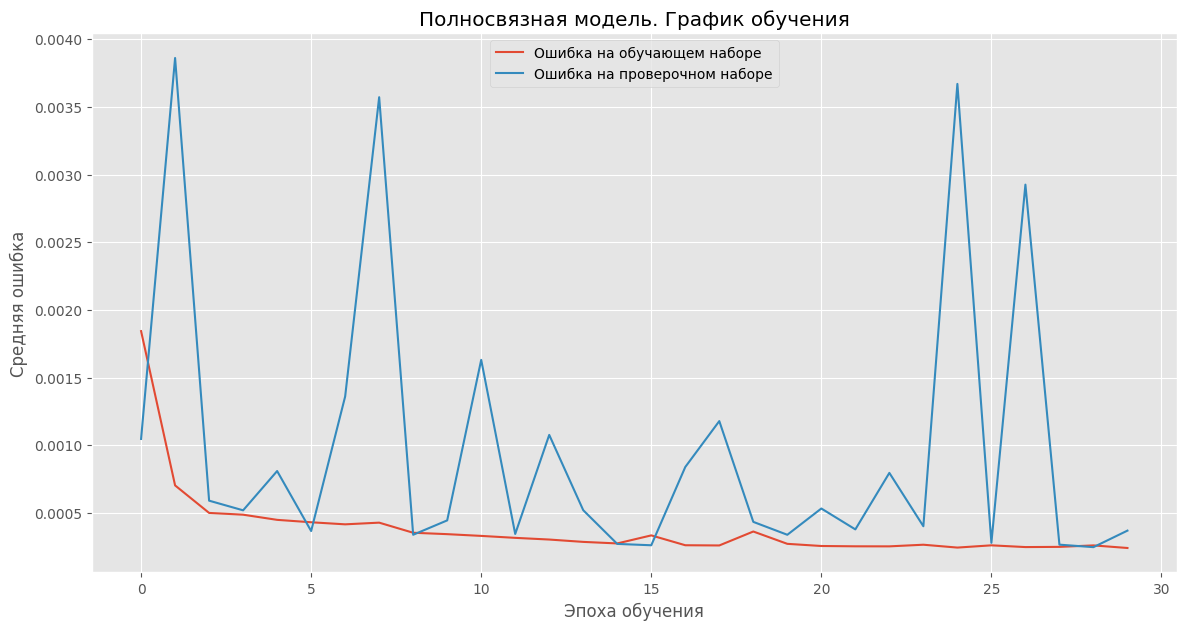

In [364]:
history_plot(model_dense.history, 'Полносвязная модель')

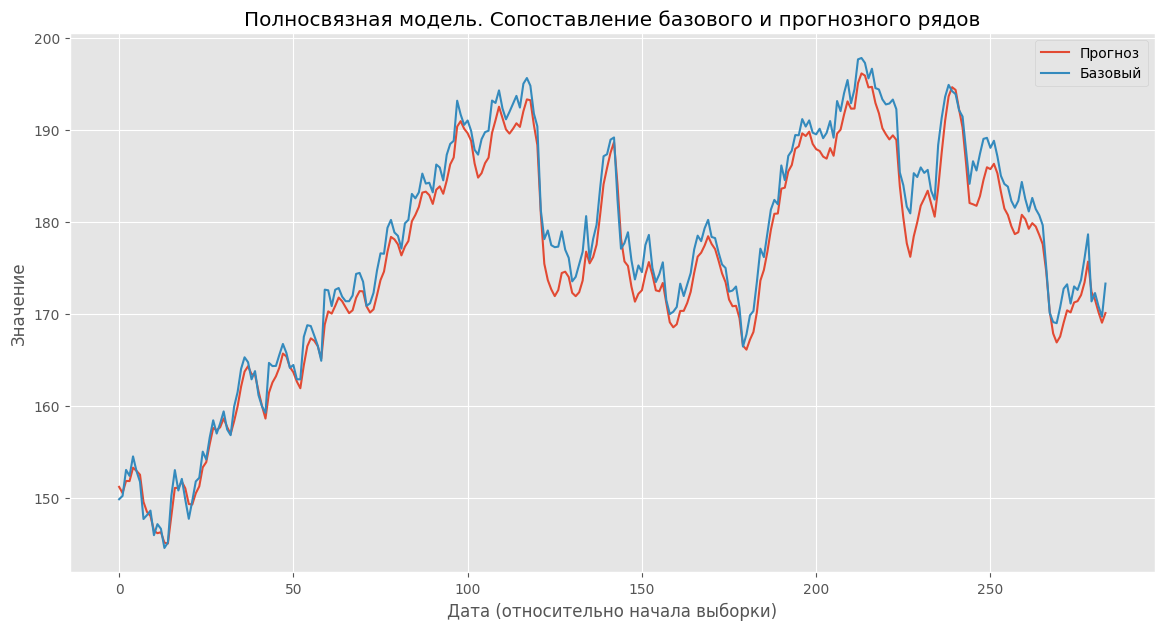

In [365]:
# Получение денормализованного предсказания и данных базового ряда
y_pred, y_true = get_pred(model_dense, x_test, y_test, scaler)

# Отрисовка графика сопоставления базового и прогнозного рядов
show_predict(y_pred, y_true, title=f'Полносвязная модель. Сопоставление базового и прогнозного рядов')

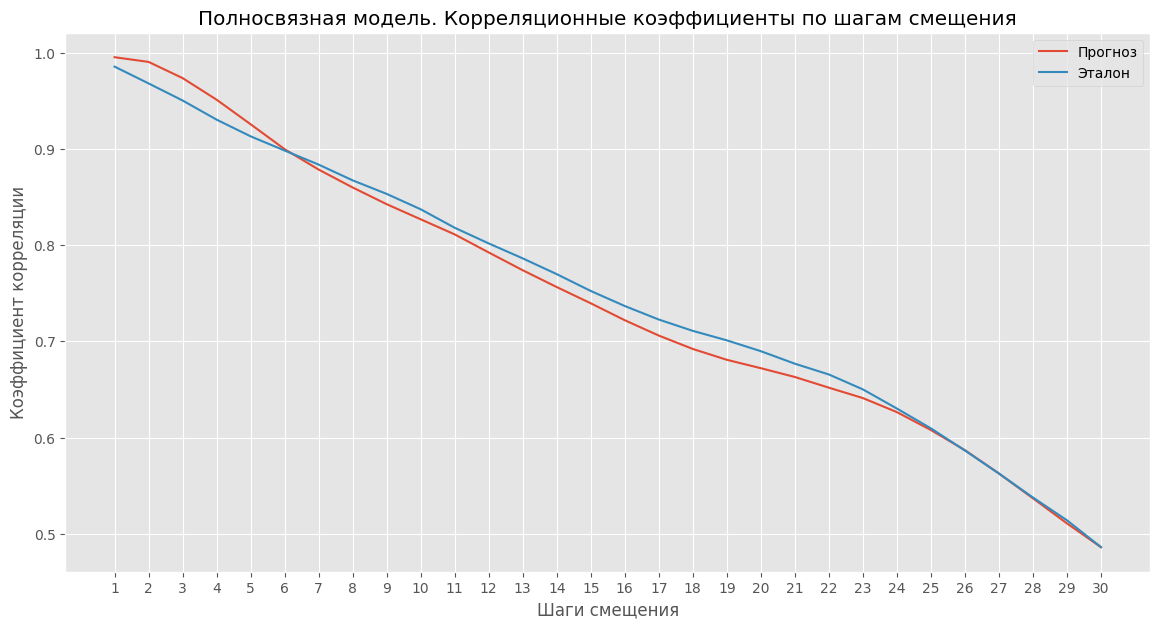

In [366]:
# Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
show_corr(y_pred, y_true, title=f'Полносвязная модель. Корреляционные коэффициенты по шагам смещения')